### Zipf's Law

Named after the American linguist George Kingsley Zipf (1902-1950), Zipf's Law describes an empirical law that describes the phenomenon in the physical and social sciences where many types of data can be approximated by Zipf distribution - a family of discrete power law probability distributions.

In linguistics, Zipf's law states that given some text of natural language, the frequency of any word is inversely proportional to its rank in the frequency table.  The most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. 

For example,
In one sample of words in the English language, the most frequently occurring word, **"the"**, accounts for nearly 7% of all the words (69,971 out of slightly over 1 million). True to Zipf's Law, the second-place word **"of"** accounts for slightly over 3.5% of words (36,411 occurrences), followed by **"and"** (28,852). 

#### Formula:

Zipf's law then predicts that frequency of element of rank $k$ can be approximated by,

$$f(k; s, N) = \frac{1/k^s}{\sum_{n=1}^N (1/n^s)}$$

where $N$ is the number of elements, and $s$ is the value of the exponent characterizing the distribution.  Normally, $s$ is defined to be $1$.

To see illustration of Wordcount example visit: http://www.wordcount.org/main.php

In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
f = lambda rank,elements,s: 1/(np.sum(1./(np.arange(1,elements+1)**s)) * rank**s)

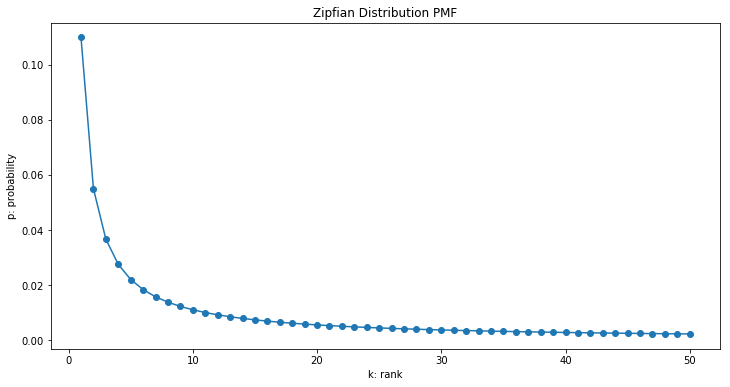

In [18]:
ranks = np.arange(1,51)
N = 5000
s = 1.0

plt.figure(figsize=(12,6))
plt.plot(ranks,f(ranks,N,s), 'o-')
plt.title("Zipfian Distribution PMF")
plt.xlabel("k: rank")
plt.ylabel("p: probability")
plt.show()

### Word Count from Project Gutenberg Free ebook Texts

This exercise will attempt to replicate the results from wordcount.org by processing a large volume of sample texts.  We'll use Spark to read the text data, process the texts, and examine the total number of unique words.  

We will sample 16 texts from [Project Gutenberg](https://www.gutenberg.org/ "Title").
Sample text files are in following location in repo:

`../data/books/`

In [ ]:
import os
os.listdir('../data/books/')

#### Load Text Files

Next, we'll load up the text files and create a text file RDD.  Spark provides `textFile` method to read a text file and return it as a RDD.

In [1]:
books_path = os.path.join('..', 'data', 'books')
textsRDD = sc.textFile(books_path + '/*.txt')
# for txt in os.listdir('data')[1:]:
#     file_dir = 'data/' + txt
#     textRDD = sc.textFile(file_dir)
#     textsRDD = textsRDD.union(textRDD)

In [2]:
textsRDD.take(20)
textsRDD.getNumPartitions()

16

In [3]:
# function to clean up the words
import re

def parsewords(sentence):
    # Convert all non-alphanumeric characters into empty string
    sentence_clean = re.sub(r'([^A-Za-z0-9\s+])', '', sentence)  
    words = sentence_clean.split(' ')
    # Convert to lowercase and eliminate empty string words
    return [word.lower() for word in words if word != ''] 

We have a a RDD that is a collection of strings.  We'll start by mapping the function `parsewords` to each of the line of strings in `textsRDD`.

In [4]:
textsRDD.map(parsewords).take(5)  # Not quite what we want!

[[],
 [],
 ['the',
  'project',
  'gutenberg',
  'ebook',
  'of',
  'adventures',
  'of',
  'huckleberry',
  'finn',
  'complete'],
 ['by', 'mark', 'twain', 'samuel', 'clemens'],
 []]

Unfortunately, the result of mapping `parsewords` to `textsRDD` did not yield the result that we want. 

RDD has `flatMap` method that will map a function that has been passed in as a parameter to elements of the RDD and flatten the result.  We'll use `flatMap` method and apply `parsewords` function to create a new RDD of words. 

In [5]:
wordRDD = textsRDD.flatMap(parsewords)
wordRDD.take(20)

['the',
 'project',
 'gutenberg',
 'ebook',
 'of',
 'adventures',
 'of',
 'huckleberry',
 'finn',
 'complete',
 'by',
 'mark',
 'twain',
 'samuel',
 'clemens',
 'this',
 'ebook',
 'is',
 'for',
 'the']

Now that we have an RDD of words, let's examine how many words are in our sample texts.

In [6]:
# Total Number of Words in our Sample
total_count = wordRDD.count()
print("Total Word Count:", total_count)

Total Word Count: 2018331


We will use `map` method of the RDD to convert each occurance of word into a (key,value) pair and create a new RDD called `wordPairRDD`.  If you saw the word count example in MapReduce, you should be familiar with this pattern. 

In [7]:
# Convert individual word into a pair of (word,1) tuple 
wordPairRDD = wordRDD.map(lambda word: (word,1))
wordPairRDD.take(20)

[('the', 1),
 ('project', 1),
 ('gutenberg', 1),
 ('ebook', 1),
 ('of', 1),
 ('adventures', 1),
 ('of', 1),
 ('huckleberry', 1),
 ('finn', 1),
 ('complete', 1),
 ('by', 1),
 ('mark', 1),
 ('twain', 1),
 ('samuel', 1),
 ('clemens', 1),
 ('this', 1),
 ('ebook', 1),
 ('is', 1),
 ('for', 1),
 ('the', 1)]

We have converted wordRDD into a a new RDD that holds each instance of word into a (key,value) pair.  Let's use reduceByKey method to sum up the counts and create a new RDD, `wordCountRDD`. 

In [8]:
wordCountRDD = wordPairRDD.reduceByKey(lambda x,y: x+y)
wordCountRDD.take(20)

[('sympathizing', 2),
 ('waitand', 1),
 ('onahab', 1),
 ('dice', 2),
 ('immortalitypreserver', 1),
 ('tools', 48),
 ('wateramerican', 1),
 ('ifif', 1),
 ('resumedof', 1),
 ('bourghs', 4),
 ('creturi', 1),
 ('stoop', 16),
 ('momentin', 1),
 ('principality', 1),
 ('birthright', 3),
 ('daughterhis', 1),
 ('185', 1),
 ('showre', 1),
 ('undissembled', 2),
 ('fared', 6)]

In [9]:
# Number of Unique Words
unique_count = wordCountRDD.count()
print("Total Unique Words:", unique_count)

Total Unique Words: 56589


Since `wordCountRDD` contains unique words and their counts, we sort them by `takeOrdered` method of RDD specifying the the ordering function to order by the values in (key,value) pairs.  We will only select top 50 words.

In [10]:
# Select Top 50 words in descending order of frequency
top50Words = wordCountRDD.takeOrdered(50, key=lambda x: -x[1]) # Use '-' to sort in descending order
top50Words

[('the', 112779),
 ('and', 70401),
 ('of', 60225),
 ('to', 55423),
 ('a', 39760),
 ('in', 33734),
 ('i', 33385),
 ('that', 27166),
 ('it', 24952),
 ('was', 22647),
 ('he', 21979),
 ('his', 20598),
 ('with', 17034),
 ('as', 16676),
 ('for', 15825),
 ('is', 15817),
 ('you', 15601),
 ('but', 14259),
 ('not', 14251),
 ('be', 13380),
 ('had', 13236),
 ('her', 12093),
 ('at', 11583),
 ('my', 11332),
 ('on', 11228),
 ('by', 10864),
 ('all', 10450),
 ('have', 9820),
 ('him', 9801),
 ('she', 9657),
 ('me', 9364),
 ('this', 9260),
 ('so', 9188),
 ('from', 8804),
 ('or', 8600),
 ('which', 8554),
 ('they', 8494),
 ('no', 7003),
 ('there', 6943),
 ('were', 6697),
 ('we', 6644),
 ('said', 6641),
 ('when', 6408),
 ('if', 6130),
 ('one', 6123),
 ('their', 6088),
 ('are', 5983),
 ('them', 5748),
 ('what', 5657),
 ('would', 5243)]

### Chaining

<img src="../img/word_count_RDD_transformation.jpeg" width="600px">

Although we have performed each transformation in separate steps, Spark enables us to perform these four steps in one line of code by chaining them together.

Although Python is strict about indentation, we use a convenient trick of wrapping a chain of RDD methods inside a parenthesis.  This trick enables us to chain multiple RDD methods in several lines of code, which enhances readability of your code. 

In [11]:
top50Words = (textsRDD.flatMap(parsewords)
                      .map(lambda word: (word,1))
                      .reduceByKey(lambda x,y: x+y)
                      .takeOrdered(50, key=lambda x: -x[1]))

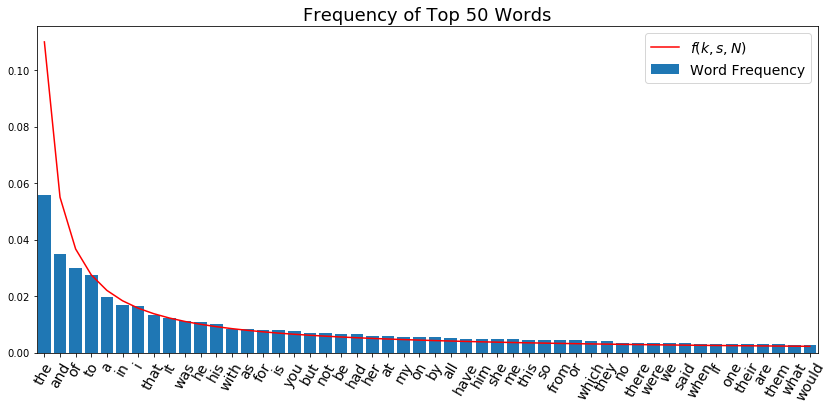

In [19]:
words = list()
counts = list()
for pair in top50Words:
    words.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(14,6))
plt.bar(range(1,51), np.array(counts) / float(total_count), label="Word Frequency", align='center')
plt.plot(ranks, f(ranks,N,s), c='r', label="$f(k,s,N)$")
plt.xticks(range(1,51), words[:50], rotation=60, fontsize=14)
plt.title("Frequency of Top 50 Words",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()

Although not exact, the word frequency from our sample of texts follows the Zipf distribution closely.  We also see that in our sample texts, "and" is the second most frequently occuring word.  This is in contrast to the word frequency ordering of BNC in which "of" is ranked second and "and" is ranked third.    